# Navigation manifold model selection

**Authors**:
  
  * Author: steevelaquitaine@epfl.ch; laquitainesteeve@gmail.com
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis.  
  * Duration: 1 hour

**Learning outcomes**:
  - Know how to <u>evaluate several hypotheses and select the best</u>. We will test whether position only, direction only and position and direction are encoded in the rat Hippocampus.

Reference: see [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
import time
t0 = time.time()

time: 2.25 ms (started: 2024-03-14 11:04:58 +00:00)


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ipython-autotime # time track colab notebook cells
%load_ext autotime
!pip install --pre 'cebra[datasets,demos]'

In [ ]:
# import software packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

time: 536 µs (started: 2024-03-14 11:05:09 +00:00)


## (1s) Loading the dataset

- The data will be automatically downloaded into a `/data` folder.

In [ ]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

time: 45.4 ms (started: 2024-03-14 11:05:09 +00:00)


## () Hypothesis testing

* We will compare models with different hypothesis on position encoding of hippocampus
* We will compare CEBRA-Behavior models trained with <u>only position</u>, <u>only direction</u>, <u>both</u> and the control models with shuffled behavior variables.
* Here, we use the set model dimension; in the paper the authors used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).
* `hippocampus_pos.continuous_index.numpy()` contains both rat's position and direction information

### () Hypothesis 1: HPC encodes position

#### (1s) Parametrize

- Set max_iterations to 100 for a quick of the code and to 5000 for robust results.
- Setting <u>conditional = ‘time_delta’</u> means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [ ]:
max_iterations = 5000 #5000 # 10000 #default is 5000.

cebra_pos_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 658 µs (started: 2024-03-14 11:05:09 +00:00)


#### (20s) Train the model

In [ ]:
# Train CEBRA-Behavior models with position only.
cebra_pos_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,0])
cebra_pos_model.save("cebra_pos_model.pt")

pos: -0.8942 neg:  6.4885 total:  5.5943 temperature:  1.0000: 100%|██████████| 5000/5000 [08:51<00:00,  9.40it/s]


time: 8min 51s (started: 2024-03-14 11:05:09 +00:00)


### (25s) Control

#### (1s) Parametrize

In [ ]:
cebra_pos_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 560 µs (started: 2024-03-14 11:14:01 +00:00)


#### (20s) Train the model

In [ ]:
# shuffle position
shuffled_pos = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,0])

# train
cebra_pos_shuffled_model.fit(hippocampus_pos.neural, shuffled_pos)

# save
cebra_pos_shuffled_model.save("cebra_pos_shuffled_model.pt")

pos: -0.6517 neg:  6.7944 total:  6.1427 temperature:  1.0000: 100%|██████████| 5000/5000 [08:58<00:00,  9.29it/s]

time: 8min 58s (started: 2024-03-14 11:14:01 +00:00)


#### (1s) Get the neural manifolds

In [ ]:
# actual data
cebra_pos = cebra_pos_model.transform(hippocampus_pos.neural)

# control
cebra_pos_shuffled_train = cebra_pos_shuffled_model.transform(hippocampus_pos.neural)

time: 43.6 ms (started: 2024-03-14 11:22:59 +00:00)


#### (1s) Plot

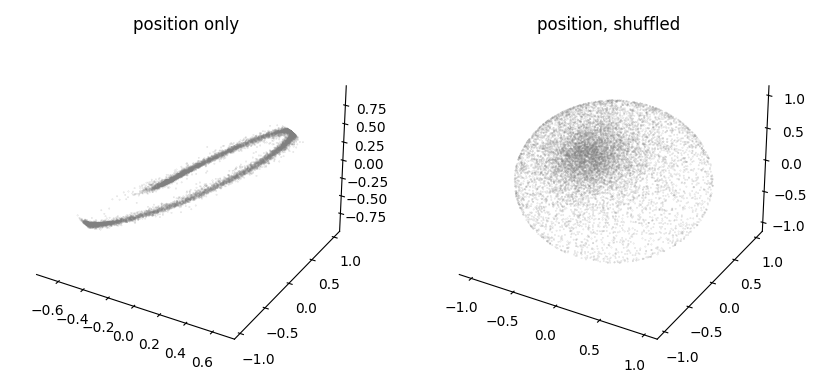

time: 431 ms (started: 2024-03-14 11:22:59 +00:00)


In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection = '3d')
ax2 = plt.subplot(122, projection = '3d')

ax1 = cebra.plot_embedding(ax=ax1,
                           embedding=cebra_pos,
                           embedding_labels="grey",
                           title='position only'
                           )

ax2 = cebra.plot_embedding(ax=ax2,
                           embedding=cebra_pos_shuffled_train,
                           embedding_labels="grey",
                           title='position, shuffled'
                           )
plt.show()

### () Hypothesis 2: HPC encodes direction

#### (1s) Parametrize

We don't set conditional here.

In [ ]:
cebra_dir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

time: 485 µs (started: 2024-03-14 11:23:00 +00:00)


#### (20s) Train the model

In [ ]:
# Train CEBRA-Behavior models with direction only.
cebra_dir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy()[:,1])
cebra_dir_model.save("cebra_dir_model.pt")

pos: -0.8849 neg:  6.5515 total:  5.6666 temperature:  1.0000: 100%|██████████| 5000/5000 [08:41<00:00,  9.58it/s]

time: 8min 41s (started: 2024-03-14 11:23:00 +00:00)


### (25s) Control

#### (1s) Parametrize

In [ ]:
cebra_dir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        device='cuda_if_available',
                        verbose=True)

time: 572 µs (started: 2024-03-14 11:31:42 +00:00)


#### (20s) Train the model

- `hippocampus_pos.continuous_index.numpy()[:,1]` contains direction information

In [ ]:
# shuffle directions
shuffled_dir = np.random.permutation(hippocampus_pos.continuous_index.numpy()[:,1])

# train
cebra_dir_shuffled_model.fit(hippocampus_pos.neural, shuffled_dir)

# save
cebra_dir_shuffled_model.save("cebra_dir_shuffled_model.pt")

pos: -0.6309 neg:  6.7032 total:  6.0722 temperature:  1.0000: 100%|██████████| 5000/5000 [10:18<00:00,  8.09it/s]

time: 10min 18s (started: 2024-03-14 11:31:42 +00:00)


### (1s) Get the neural manifolds

In [ ]:
# actual data
cebra_dir_model = cebra.CEBRA.load("cebra_dir_model.pt")
cebra_dir = cebra_dir_model.transform(hippocampus_pos.neural)

# control
cebra_dir_shuffled_model = cebra.CEBRA.load("cebra_dir_shuffled_model.pt")
cebra_dir_shuffled_train = cebra_dir_shuffled_model.transform(hippocampus_pos.neural)

time: 60 ms (started: 2024-03-14 11:42:00 +00:00)


### (1s) Plot

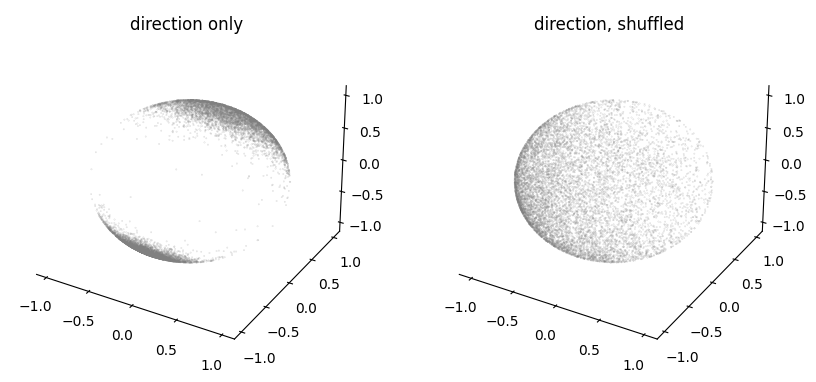

time: 432 ms (started: 2024-03-14 11:42:00 +00:00)


In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection = '3d')
ax2 = plt.subplot(122, projection = '3d')

ax1 = cebra.plot_embedding(ax=ax1,
                           embedding=cebra_dir,
                           embedding_labels="grey",
                           title='direction only'
                           )

ax2 = cebra.plot_embedding(ax=ax2,
                           embedding=cebra_dir_shuffled_train,
                           embedding_labels="grey",
                           title='direction, shuffled'
                           )
plt.show()

### () Hypothesis 3: HPC encodes both position and direction

#### (1s) Parametrize

- Setting <u>conditional = ‘time_delta’</u> means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.

In [ ]:
cebra_posdir_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 522 µs (started: 2024-03-14 11:42:00 +00:00)


#### (20s) Train the model

In [ ]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_posdir_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir_model.save("cebra_posdir_model.pt")

pos: -0.8949 neg:  6.4211 total:  5.5262 temperature:  1.0000: 100%|██████████| 5000/5000 [09:28<00:00,  8.79it/s]

time: 9min 28s (started: 2024-03-14 11:42:00 +00:00)


### (25s) Control

#### (1s) Parametrize

In [ ]:
cebra_posdir_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

time: 638 µs (started: 2024-03-14 11:51:29 +00:00)


#### (20s) Train the model

In [ ]:
# Generate shuffled behavior labels for train set.
shuffled_posdir = np.random.permutation(hippocampus_pos.continuous_index.numpy())

# Train the models with shuffled behavior variables
cebra_posdir_shuffled_model.fit(hippocampus_pos.neural, shuffled_posdir)
cebra_posdir_shuffled_model.save("cebra_posdir_shuffled_model.pt")


pos: -0.6342 neg:  6.7874 total:  6.1532 temperature:  1.0000: 100%|██████████| 5000/5000 [09:15<00:00,  9.00it/s]

time: 9min 15s (started: 2024-03-14 11:51:29 +00:00)


### (1s) Get neural manifolds

In [ ]:
# actual data
cebra_posdir_model = cebra.CEBRA.load("cebra_posdir_model.pt")
cebra_posdir = cebra_posdir_model.transform(hippocampus_pos.neural)

# control
cebra_posdir_shuffled_model = cebra.CEBRA.load("cebra_posdir_shuffled_model.pt")
cebra_posdir_shuffled_train = cebra_posdir_shuffled_model.transform(hippocampus_pos.neural)


time: 57.3 ms (started: 2024-03-14 12:00:44 +00:00)


### (1s) Plot

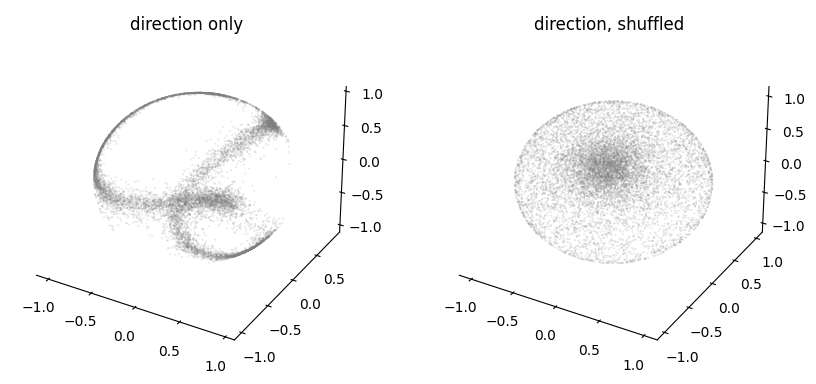

time: 485 ms (started: 2024-03-14 12:00:44 +00:00)


In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121, projection = '3d')
ax2 = plt.subplot(122, projection = '3d')

ax1 = cebra.plot_embedding(ax=ax1,
                           embedding=cebra_posdir,
                           embedding_labels="grey",
                           title='direction only'
                           )

ax2 = cebra.plot_embedding(ax=ax2,
                           embedding=cebra_posdir_shuffled_train,
                           embedding_labels="grey",
                           title='direction, shuffled'
                           )
plt.show()

### Compare all manifolds

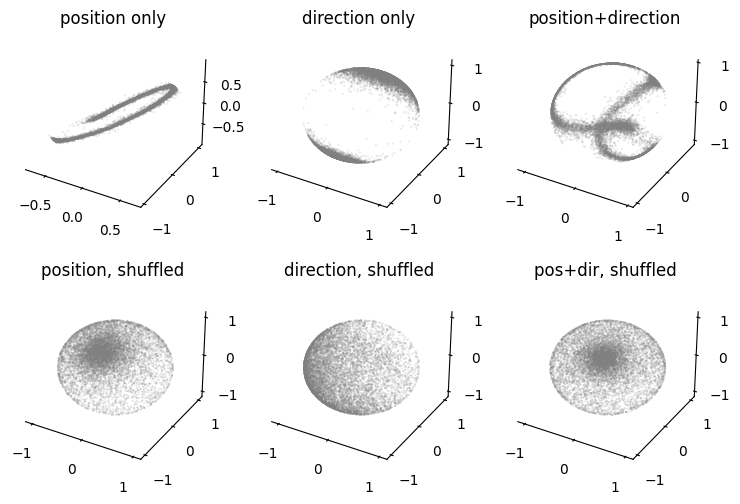

time: 1.15 s (started: 2024-03-14 12:00:45 +00:00)


In [ ]:
fig=plt.figure(figsize=(9,6))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_pos, embedding_labels="grey", title='position only')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_dir, embedding_labels="grey", title='direction only')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_posdir, embedding_labels="grey", title='position+direction')
ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_pos_shuffled_train, embedding_labels="grey", title='position, shuffled')
ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_dir_shuffled_train, embedding_labels="grey", title='direction, shuffled')
ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_posdir_shuffled_train, embedding_labels="grey", title='pos+dir, shuffled')

plt.show()

### Plot the loss of the models

- We will use the converged loss functions to evaluate the models and select the model with the lowest converged loss as the best explanation for the data.

- Which hypothesis is supported by the strongest evidence?

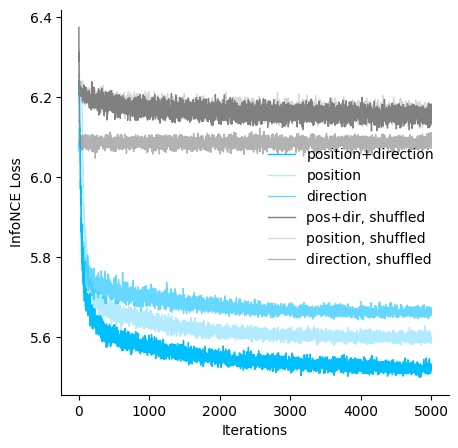

time: 1.07 s (started: 2024-03-14 12:00:46 +00:00)


In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_posdir_model, color='deepskyblue', label='position+direction', ax=ax)
ax = cebra.plot_loss(cebra_pos_model, color='deepskyblue', alpha=0.3, label='position', ax=ax)
ax = cebra.plot_loss(cebra_dir_model, color='deepskyblue', alpha=0.6,label='direction', ax=ax)

ax = cebra.plot_loss(cebra_posdir_shuffled_model, color='gray', label='pos+dir, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_pos_shuffled_model, color='gray', alpha=0.3, label='position, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_dir_shuffled_model, color='gray', alpha=0.6, label='direction, shuffled', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.show()

In [ ]:
print("The notebook execution took:", np.round(time.time() - t0),1)

The notebook execution took: 3349.0 1
time: 2.06 ms (started: 2024-03-14 12:00:47 +00:00)
